# 作业要求
<p style="font-size:18px;">1. 将 PaddlePaddle2.x 训练模型转换成 Hub 模型；</p>
<p style="font-size:18px;">2. 在 AI Studio 终端部署 Hub 模型并用Python代码推理；</p>

# 预期成果
<p style="font-size:18px;">1. 能够使用 <span style="font-style:italic;color:#f00;">hub install module_name</span> 安装模型并且 <span style="font-style:italic;color:#f00;">hub run module_name</span> 可以成功预测</p>
<p style="font-size:18px;">2. 通过 <span style="font-style:italic;color:#f00;">hub serving start</span> 部署到 终端-1 ，用Python进行POST请求预测</p>

# 参考资料
<a style="font-size:18px;" href="https://www.paddlepaddle.org.cn/hub" target="_blank">PaddleHub官网</a>

<a style="font-size:18px;" href="https://aistudio.baidu.com/aistudio/projectdetail/2209039" target="_blank">CV模型转换参考</a>

<a style="font-size:18px;" href="https://paddlehub.readthedocs.io/zh_CN/release-v2.1/tutorial/custom_module.html" target="_blank">NLP模型转换参考</a>

In [8]:
!pip install --upgrade paddlepaddle -i https://mirror.baidu.com/pypi/simple
!pip install --upgrade paddlehub -i https://mirror.baidu.com/pypi/simple
!pip install paddleseg

In [6]:
%cd work

[Errno 2] No such file or directory: 'work'
/home/aistudio/work


In [19]:
!pip show paddlehub

In [10]:
import paddlehub
paddlehub.server_check()

[2021-08-15 07:34:35,965] [    INFO] - Request Hub-Server successfully.


True

## 作业内容开始

主要看下面的调用和 
/home/aistudio/work/seg_predict

In [22]:
! hub install /home/aistudio/work/seg_predict

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is depre

## 在这里利用hub来调用自己训练的模型

forward
img is a path


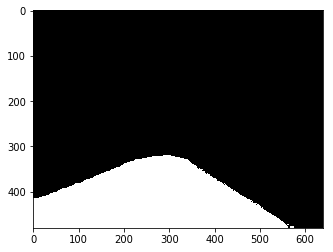

(array([0, 1], dtype=uint8), array([0, 1], dtype=uint8))

In [23]:
import paddlehub as hub
from matplotlib import pyplot as plt
import numpy as np

test_img = '/home/aistudio/work/test_img/boxhill_095.jpeg'
my_seg = hub.Module(name="bisenetv2_predict")
result = my_seg.seg_predict(test_img)

# highlight the road segmentation by inverting the pixel values
overlay = 1 - result
plt.imshow(overlay, interpolation='nearest', cmap='gray')
plt.show()

np.unique(overlay),np.unique(result)

## 最后把原图和分割的mark重合起来显示一下效果

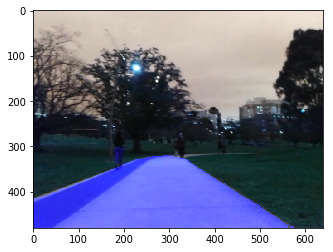

In [24]:
import cv2

overlay = overlay * 255
overlay_img = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
overlay_path = '/home/aistudio/work/test_img/overlay.png'
cv2.imwrite(overlay_path, overlay_img)

background = cv2.imread(test_img)
overlay_img[:,:,0] = overlay_img[:,:,0] * 0
overlay_img[:,:,1] = overlay_img[:,:,1] * 0
added_image = cv2.addWeighted(background,1,overlay_img,0.6,0)

plt.imshow(added_image)

## 部署Hub模型到本地服务器

首先要确保 已经安装了 自己的 module, 然后在终端运行如下命令:

`hub serving start -m bisenetv2_predict`

或者 在notebook里面

`!hub serving start -m bisenetv2_predict`

接下来 URL的格式是个大坑....当你运行了上面的命令行后 它并不会告诉你正确的endpoint的URL 

它只会告诉你 'http://0.0.0.0:8866/'.....

而且官方文档上会说URL的格式是如下:
base_url+/predict/Category/module_name

这里Category的值如下
Category: text, image

Module Name: 就是你自己给你的module起得名字 @moduleinfo(name="bisenetv2_predict",...)

### 但是!! 你加了Category它反而会报错
### JSONDecodeError: Expecting value: line 1 column 1 (char 0)

真是深远大坑啊~!! 我的七夕一整天就是在这个坑里渡过了.....


所以真正正确的URL格式是:
***baseurl+/predict/modulename***

> 同时一点心得:
> Python不像C#一样是强类型语言,所以好用.但是....却有时让我们不知道传参的时候 互相之间传的参数应该是什么类型,这个也是花了我很多时间的地方.所以我在下面的代码种都标注出了每个重要关键点变量的参数类型,方便大家在debug的时候发现问题.
> 
完整代码如下

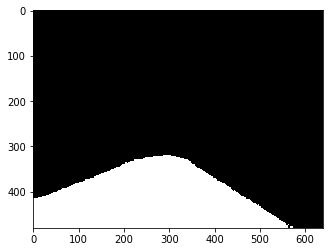

In [40]:
import requests
import json
import base64
import os
from io import BytesIO

def cv2_to_base64(image): # the image is a BGR numpy array
    data = cv2.imencode('.jpeg', image)[1] # data is numpy array with values of encoded img bytes
    return base64.b64encode(data.tobytes()).decode('utf-8')

def base64_to_np_array(b64Str):
    img_b = base64.b64decode(b64Str)
    img_stream = BytesIO(img_b)
    img = cv2.imdecode(np.frombuffer(img_stream.read(), np.uint8), 1)
    return img

data = {'img_b64': cv2_to_base64(cv2.imread(test_img))}
headers = {"Content-Type": "application/json"}
url = "http://0.0.0.0:8866/predict/bisenetv2_predict"
res = requests.post(url=url, headers=headers, data=json.dumps(data))

data = res.json()
# data looks like this:
# {
#     'msg': '', 
#     'results': '{"res": "/9j/4AAQSkZJRgABAQAAAQABAAD/....oooo...."}'

img_data = json.loads(data['results']) # img_data is a Python object, data['results] is one of str, bytes etc.
res_img_np = base64_to_np_array(img_data['res']) # res_img_np is an numpy array

# invert the mask
img_255 = 255 - res_img_np * 255
plt.imshow(img_255)